# Final project

### Author: Roberto Corti

The Allen–Cahn equation (after John W. Cahn and Sam Allen) is a reaction–diffusion equation of mathematical physics which describes the process of phase separation in multi-component alloy systems, including order-disorder transitions.

The equation describes the time evolution of a scalar-valued state variable $\eta$  on a domain $\Omega=[0,1]$  during a time interval $[0,T]$, and is given (in one dimension) by:

$$
\frac{\partial \eta}{\partial t} - \varepsilon^2 \eta'' + f'(\eta) = 0, \qquad \eta'(0, t) = \eta'(1, t) = 0,\qquad\eta(x,0) = \eta_0(x)
$$

where $f$ is a double-well potential, $\eta_0$ is the initial condition, and $\varepsilon$ is the characteristic width of the phase transition.

This equation is the L2 gradient flow of the Ginzburg–Landau free energy functional, and it is closely related to the Cahn–Hilliard equation.

A typical example of double well potential is given by the following function

$$
f(\eta) = \eta^2(\eta-1)^2
$$

which has two minima in $0$ and $1$ (the two wells, where its value is zero), one local maximum in $0.5$, and it is always greater or equal than zero.

The two minima above behave like "attractors" for the phase $\eta$. Think of a solid-liquid phase transition (say water+ice) occupying the region $[0,1]$. When $\eta = 0$, then the material is liquid, while when $\eta = 1$ the material is solid (or viceversa).

Any other value for $\eta$ is *unstable*, and the equation will pull that region towards either $0$ or $1$.

Discretisation of this problem can be done by finite difference in time. For example, a fully explicity discretisation in time would lead to the following algorithm.

We split the interval $[0,T]$ in `n_steps` intervals, of dimension `dt = T/n_steps`. Given the solution at time `t[k] = k*dt`, it i possible to compute the next solution at time `t[k+1]` as

$$
\eta_{k+1} = \eta_{k} + \Delta t \varepsilon^2 \eta_k'' - \Delta t f'(\eta_k)
$$

Such a solution will not be stable. A possible remedy that improves the stability of the problem, is to treat the linear term $\Delta t \varepsilon^2 \eta_k''$ implicitly, and keep the term $-f'(\eta_k)$ explicit, that is:

$$
\eta_{k+1} - \Delta t \varepsilon^2 \eta_k'' = \eta_{k} - \Delta t f'(\eta_k)
$$

Grouping together the terms on the right hand side, this problem is identical to the one we solved in the python notebook number 9, with the exception of the constant $\Delta t \varepsilon^2$ in front the stiffness matrix.

In particular, given a set of basis functions $v_i$, representing $\eta = \eta^j v_j$ (sum is implied), we can solve the problem using finite elements by computing

$$
\big((v_i, v_j) + \Delta t \varepsilon^2  (v_i', v_j')\big) \eta^j_{k+1} = \big((v_i, v_j) \eta^j_{k} - \Delta t (v_i, f'(\eta_k)\big)
$$
where a sum is implied over $j$ on both the left hand side and the right hand side. Let us remark that while writing this last version of the equation we moved from a forward Euler scheme to a backward Euler scheme for the second spatial derivative term: that is, we used $\eta^j_{k+1}$ instead of $\eta^j_{k}$.  

This results in a linear system

$$
A x = b
$$

where 

$$
A_{ij} = M_{ij}+ \Delta t \varepsilon^2 K_{ij} = \big((v_i, v_j) + \Delta t \varepsilon^2  (v_i', v_j')\big) 
$$

and 

$$
b_i = M_{ij} \big(\eta_k^j - \Delta t f'(\eta_k^j)\big)
$$

where we simplified the integration on the right hand side, by computing the integral of the interpolation of $f'(\eta)$.

## Step 1

Write a finite element solver, to solve one step of the problem above, given the solution at the previous time step, using the same techniques used in notebook number 9.

In particular:

1. Write a function that takes in input a vector representing $\eta$, an returns a vector containing $f'(\eta)$. Call this function `F`.

2. Write a function that takes in input a vector of support points of dimension `ndofs` and the degree `degree` of the polynomial basis, and returns a list of basis functions (piecewise polynomial objects of type `PPoly`) of dimension `ndofs`, representing the interpolatory spline basis of degree `degree`

3. Write a function that, given a piecewise polynomial object of type `PPoly` and a number `n_gauss_quadrature_points`, computes the vector of global_quadrature_points and global_quadrature_weights, that contains replicas of a Gauss quadrature formula with `n_gauss_quadrature_points` on each of the intervals defined by `unique(PPoly.x)`

4. Write a function that, given the basis and the quadrature points and weights, returns the two matrices $M$ and $K$ 

## Step 2

Solve the Allen-Cahan equation on the interval $[0,1]$, from time $t=0$ and time $t=1$, given a time step `dt`, a number of degrees of freedom `ndofs`, and a polynomial degree `k`.

1. Write a function that takes the initial value of $\eta_0$ as a function, eps, dt, ndofs, and degree, and returns a matrix of dimension `(int(T/dt), ndofs)`  containing all the coefficients $\eta_k^i$ representing the solution, and the set of basis functions used to compute the solution

2. Write a function that takes all the solutions `eta`, the basis functions, a stride number `s`, and a resolution `res`, and plots on a single plot the solutions $\eta_0$, $\eta_s$, $\eta_{2s}$, computed on `res` equispaced points between zero and one

## Step 3

Solve the problem for all combinations of

1. eps = [01, .001]

2. ndofs = [16, 32, 64, 128]

3. degree = [1, 2, 3]

3. dt = [.25, .125, .0625, .03125, .015625]

with $\eta_0 = \sin(2 \pi x)+1$.

Plot the final solution at $t=1$ in all cases. What do you observe? What happens when you increase ndofs and keep dt constant? 

## Step 4 (Optional)

Instead of solving the problem explicitly, solve it implicitly, by using backward euler method also for the non linear term. This requires the solution of a Nonlinear problem at every step. Use scipy and numpy methods to solve the non linear iteration.

In [1]:
%pylab inline
import sympy as sym
import scipy
from scipy.interpolate import *
from scipy.integrate import *
from scipy import optimize

Populating the interactive namespace from numpy and matplotlib


## Step 1

1. The function `F`computes the first derivative of the double-well potential function, that is 

$$ f'(\eta) = 2\eta(\eta-1)(2\eta-1) $$  

In [2]:
# Step 1.1

def F(eta):
    return 2*eta*(eta-1)*(2*eta-1)

2. The function `compute_basis_functions` computes the piecewise polynomial basis functions, representing the interpolatory spline basis of degree `degree`. As arguments it will require `support_points`, that is a list of points, and the `degree` of the piecewise polynomials. 

In [3]:
# Step 1.2

def compute_basis_functions(support_points, degree):
    ''' 
    Computes piecewise polynomial basis function.
    '''
    basis = []
    M = len(support_points)
    for i in range(M):
        c = support_points*0                                       # c = [0,0,....,0]
        c[i] = 1                                                   # c = [0,0,..1,.0]
        bi = PPoly.from_spline(splrep(support_points,c,k=degree))  # construct a piecewise polynomial from spline
        basis.append(bi)
        
    return basis

3. The function `compute_global_quadrature`, given as input the basis functions and an integer `n_gauss_quadrature_points`, computes global quadrature points and global quadrature weights used for integration.

In [4]:
# Step 1.3

def compute_global_quadrature(basis, n_gauss_quadrature_points):
    '''
    Create a Gauss quadrature formula with n_gauss_quadrature_points, extract the intervals from basis,
    create len(x)-1 shifted and scaled Gauss quadrature formulas that can be used to integrate on each interval.  
    Return the result
    '''
    
    intervals = unique(basis[0].x)  # Make sure every interval border is taken only once

    qp, w = numpy.polynomial.legendre.leggauss(n_gauss_quadrature_points+1)  #computes sample points and weights 
                                                                             # for Gauss-Legendre quadrature for [-1,1]    
    qp = (qp+1)/2      # Rescale the points and weights to work from zero to one
    w /= 2
    
    h = diff(intervals)
    gloabl_quadrature = array([intervals[i]+h[i]*qp for i in range(len(h))]).reshape((-1,))
    global_weights = array([w*h[i] for i in range(len(h))]).reshape((-1,))
    return gloabl_quadrature, global_weights
    

3. Given the basis, the global quadrature points and weights the function `compute_system_matrices` computes the two matrices $M=(v_i,v_j)$ and $K=(v_i',v_j')$:

In [5]:
# Step 1.4

def compute_system_matrices(basis, gloabl_quadrature, global_weights):
    '''
    Compute the matrices M_ij = (v_i, v_j) and K_ij = (v_i', v_j') and return them
    '''
    M = len(basis)
    dbasis = []
    for i in range(M):
        dbasis.append(basis[i].derivative(1))
    Bq = array([basis[i](gloabl_quadrature) for i in range(M)]).T
    dBq = array([dbasis[i](gloabl_quadrature) for i in range(M)]).T
    M = einsum('qi, q, qj', Bq, global_weights, Bq)
    K = einsum('qi, q, qj', dBq, global_weights, dBq)
    return M, K


## Step 2

The function `solve_allen_cahan` returns the solutions $\eta_k^i$ at each time step $t_k$ and the set of basis functions used to compute the solution. 
As initial function, I decide to use 
$\eta_0 = \sin(2\pi x) +1$

In [8]:
#initial function

def eta_0(x):
    return sin(2*pi*x)+1

In [9]:
# Step 2.1

def solve_allen_cahan(eta_0_function, eps, dt, ndofs, degree):
    '''
    Forward Euler solution.
    Produce as result a matrix eta, containing the solution at all points, and basis.
    '''
    q = linspace(0,1, ndofs)                                # array of points
    basis = compute_basis_functions(q, degree)              # create basis from q
    Q, W = compute_global_quadrature(basis, degree+1)       # compute quadrature for having matrixes M and K
    M, K = compute_system_matrices(basis, Q, W)             # compute M,K matrixes
    A = M + (dt*eps**2)*K                                   # compute A matrix
    N_step = int(1/dt)                                      # compute number of steps to do
    time_interval= [i*dt for i in range(N_step+1)]          # creates list of times
    eta = zeros((len(time_interval), ndofs))                # creates matrix of eta where I'll store each eta_k(t_h)
    eta_k = eta_0_function(q)                               # initial function 
    eta[0,:] = eta_k
    for t in range(1,len(time_interval)):                   # solving linear system Ax=b at each step (x=eta_k)
        b = M.dot((eta_k -dt*F(eta_k)))
        eta_k = linalg.solve(A, b)
        eta[t,:] = eta_k
        
    return eta, basis                                       # return eta matrix and basis functions
    

The function `plot_solution` produces a plot of the solutions $\eta_0$, $\eta_s$, $\eta_{2s}$ computed on `resolution` equispaced points between $0$ and $1$:

In [10]:
# Step 2.2 

def plot_solution(eta, basis, stride, resolution):
    # plot eta[::stride], on x = linspace(0,1,resolution)
    x = linspace(0,1,resolution)
    B = zeros((resolution, len(basis)))
    for i in range(len(basis)):
        B[:,i] = basis[i](x)
       
    n_t = shape(eta)[0]
    t = ['t ='+str(round((i/(n_t-1)),2)) for i in range(n_t)]
    for eta,label_t in zip(eta[::-stride],t[::-stride]):
        plot(x, eta.dot(B.T),label=label_t)
        
    _= legend(fontsize='x-large')
    _= title('Allen–Cahn equation solution $\eta(x,t)$', fontsize=25)
    _= xlabel('$x$', fontsize=20)
    _= ylabel('$\eta$', fontsize=20)

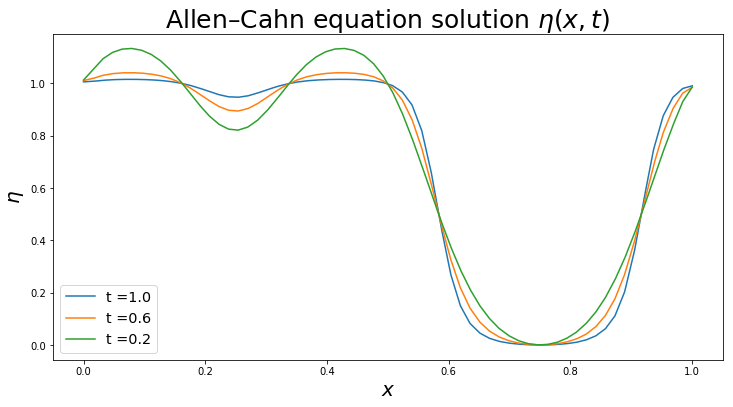

In [11]:
figure(figsize=(12,6))

eta, basis = solve_allen_cahan(eta_0, eps=0.01, dt=0.1, ndofs=64, degree=1)

_= plot_solution(eta, basis, stride=4, resolution=1025)

## Step 3

The functions `plot_increasing_ndofs`, `plot_increasing_dt`, `plot_increasing_degree`, `plot_increasing_eps` will plot the final solution $\eta(x, t=1)$ as increasing, for each associate function, `ndofs`, `dt`, `degree` and `eps`. I decide to vary the parameters at the following values:

```
eps = [01, .001]

ndofs = [16, 32, 64, 128]

degree = [1, 2, 3]

dt = [.25, .125, .0625, .03125, .015625]
```

In [12]:
#parameters

resolution = 1025
eps = [.01, .001]
ndofs = [16, 32, 64, 128]
degree = [1, 2, 3]
dt = [.25, .125, .0625, .03125, .015625]

In [18]:
# function for increase ndofs and fixed dt,eps,degree

def plot_increasing_ndofs(eps, degree, dt):
    ndofs = [16, 32, 64, 128]
    fig = figure(figsize=(22,11))
    for i in range(len(ndofs)):
        eta, basis = solve_allen_cahan(eta_0, eps, dt, ndofs[i], degree)
        subplot(2,2,i+1)
        plot_solution(eta, basis, int(1/dt+1), 1025)
        title('ndofs = '+ str(ndofs[i]), fontsize=18)
        legend(fontsize='x-large')
        xlabel('x', fontsize=10)
        ylabel('$\eta$', fontsize=10)  
    
    print('eps = '+str(eps)+', deg = '+str(degree)+', dt = '+ str(dt))
    
    
def plot_increasing_dt(eps, degree, ndofs):
    dt = [.25, .125, .0625, .03125, .015625]
    fig = figure(figsize=(18,28))
    for i in range(len(dt)):
        eta, basis = solve_allen_cahan(eta_0, eps, dt[i], ndofs, degree)
        subplot(5,3,i+1)
        plot_solution(eta, basis, int(1/dt[i]+1), 1025)
        title('eps = '+str(eps)+', degree = '+str(degree)+', ndofs = '+ str(ndofs)
              +', dt = '+ str(dt[i]), fontsize=12)
        legend(fontsize='x-large')
        xlabel('x', fontsize=10)
        ylabel('$\eta$', fontsize=10)  
    
    
    
def plot_increasing_eps(dt, degree, ndofs):
    eps = [.1, .01, .001]
    fig = figure(figsize=(16,7))
    for i in range(len(eps)):
        eta, basis = solve_allen_cahan(eta_0, eps[i], dt, ndofs, degree)
        subplot(1,3,i+1)
        plot_solution(eta, basis, int(1/dt+1), 1025)
        title('eps = '+ str(eps[i]), fontsize=15)
        legend(fontsize='x-large')
        xlabel('x', fontsize=10)
        ylabel('$\eta$', fontsize=10)  
    
    
    print('dt = '+str(dt)+', degree = '+str(degree)+', ndofs = '+ str(ndofs))

eps = 0.001, deg = 1, dt = 0.03125


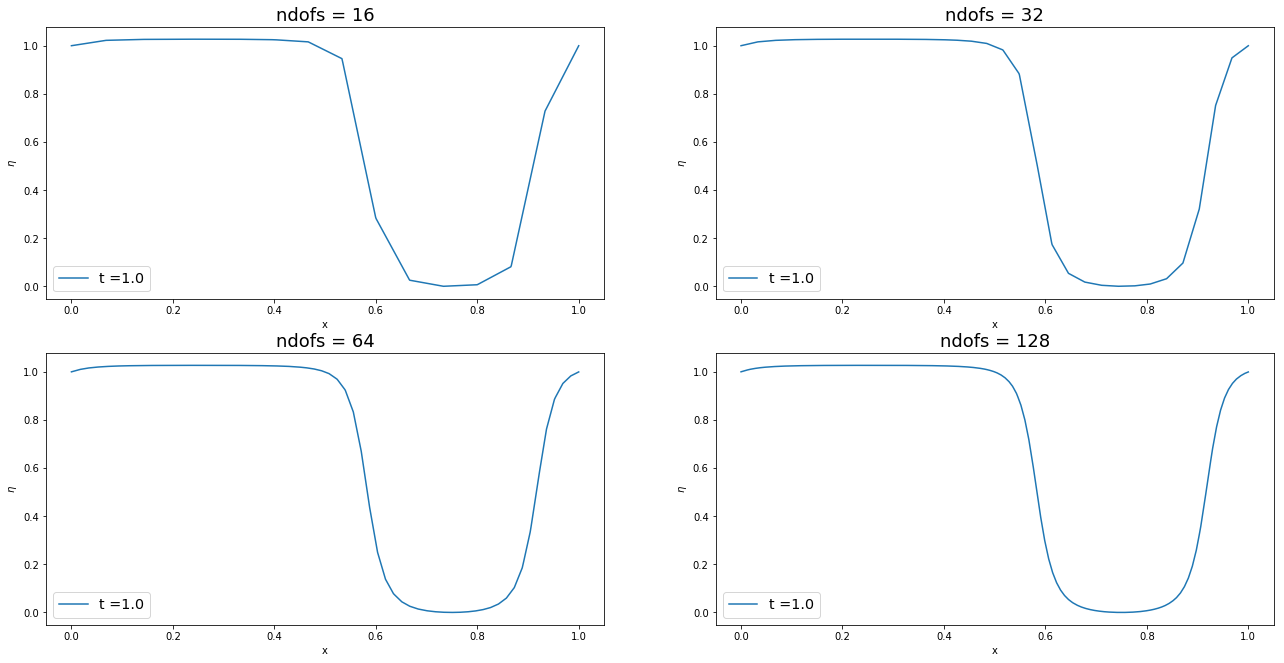

In [19]:
plot_increasing_ndofs(eps[1], degree[0], dt[3])

As first observation, I note that the solution becomes smoother when increasing the number of degrees of freedom (`ndofs`) and keeping `dt`, `eps` and `degree` constant. This behaviour can be explained by the fact that as we are increasing the `support_points` in `compute_basis_function` our polynomial aproximation becomes more close to the solution $\eta(x,t=1)$

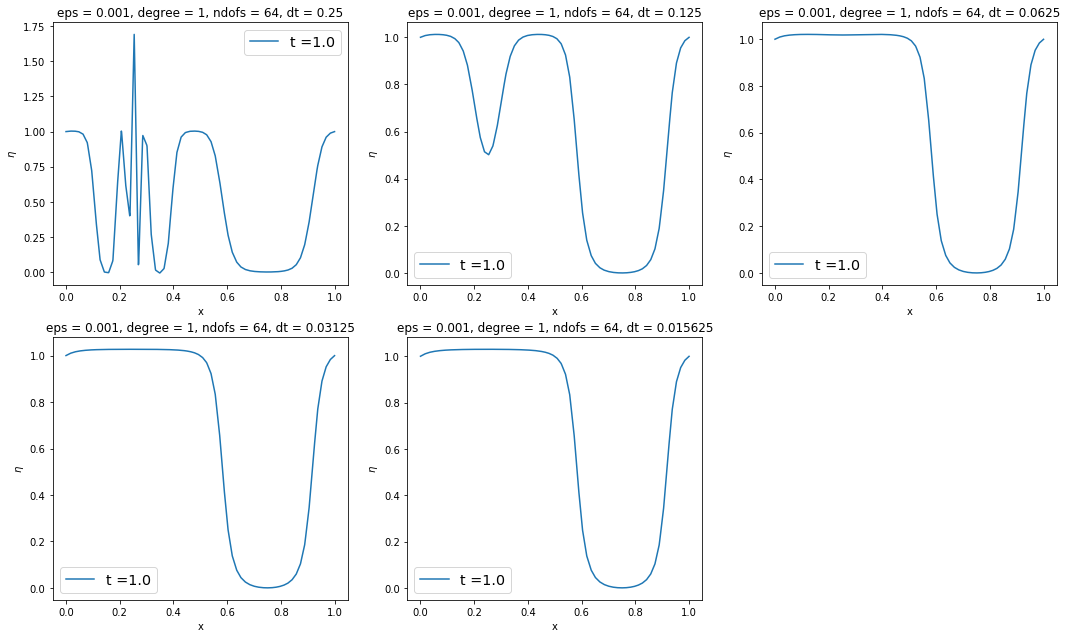

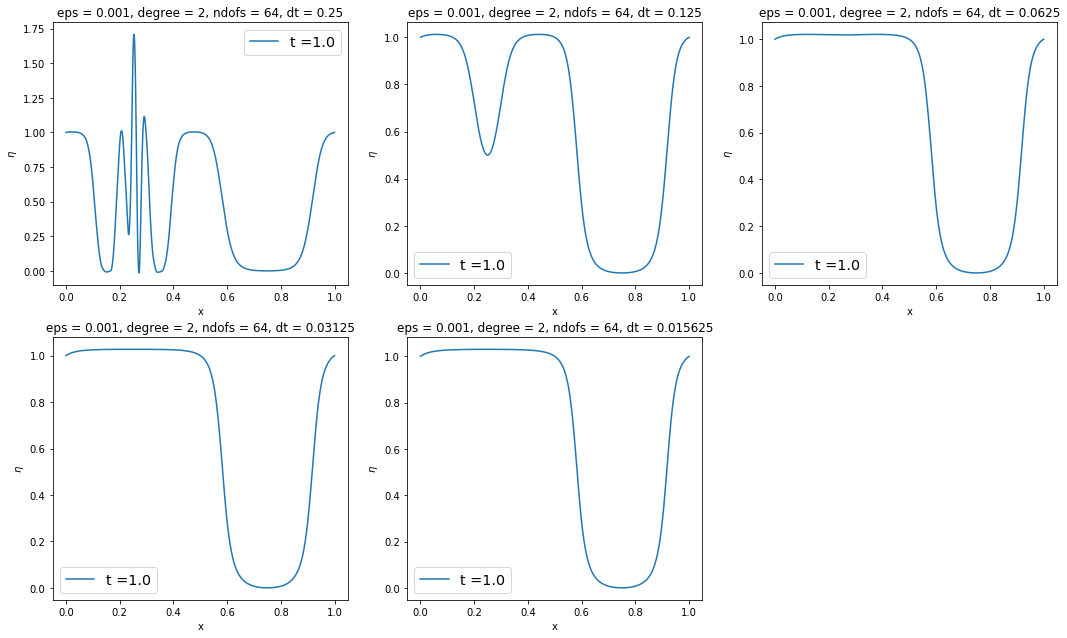

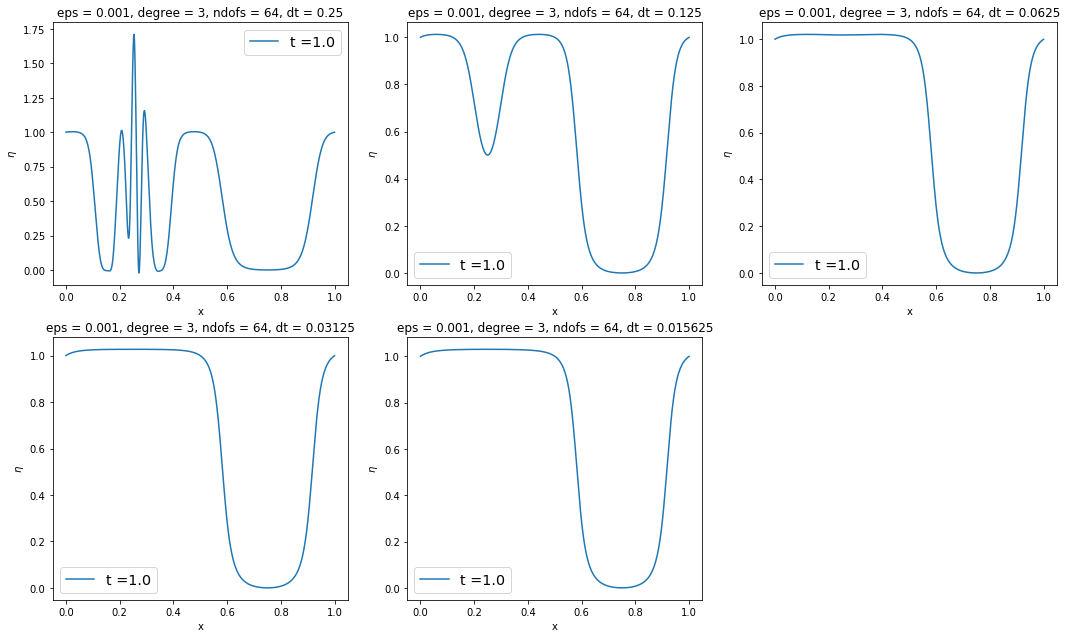

In [20]:
for deg in degree:
    plot_increasing_dt(eps[1], deg, ndofs[2])

From these plots it is possible to notice that the solution tends to $0$ for $x<0.5$ and to $1$ for $x>0.5$.  However, for large `dt` (`dt=0.25` and `dt=0.125`) the solution is unstable since the forward Euler method is conditionally stable.

## Step 4

By applying Backward Euler method we consider the following equation 

 $$ \frac{\partial \eta}{\partial t} \simeq \frac{(\eta_{k+1} - \eta_k)}{\Delta t}  = \varepsilon^2 \eta_{k+1} '' - f'(\eta_{k+1}). $$
 
 Then, using the same discretiazation procedure done in **Step 2** and with our basis representation $\eta=\eta^{j}v_j$ we end up with the following non linear equation
 
 $$ \big((v_i, v_j) + \Delta t \varepsilon^2  (v_i', v_j')\big) \eta^j_{k+1} + \Delta t (v_i, f'(\eta^j_{k+1})) - (v_i, v_j) \eta^j_{k} = 0.  $$
 
 Defining the matrix $A_{ij} = M_{ij} + \Delta t \varepsilon^2 K_{ij}$, where $ M_{ij} = (v_i, v_j) $ and $ K_{ij} = (v_i', v_j') $, the equation can be written in this compact form 
 
 $$ \boxed {F_i(\eta^j_{k+1}) := A_{ij}\eta^j_{k+1} - M_{ij}\eta^j_k + \Delta t M_{ij} f'(\eta^j_{k+1}) = 0} $$ 
 
 Thus, in order to implement a numerical method I have to find the value of $\eta^j_{k+1}$ that satisfies $F_i(\eta^j_{k+1}) =0$. This is equivalent to find for every time step the root of the given function.
 
 In my implementation `solve_solve_allen_cahan_non_linear` I decide to use methods provided by `scipy`. After using several methods I find out that the method [`optimize.root`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.root.html) results the most efficient one. This function requires as arguments the function $F_i$ and its realative jacobian matrix $\partial_j F_i$. As did in `solve_solve_allen_cahan` the outputs are the solution, that is stored in a matrix of dimension (`time_steps`, `ndofs`), and the `basis` functions.

In [22]:
# Step 4

def F_prime(eta):                       
    return 12*eta*(eta-1) + 2       #second derivative of f. I need for Jacobian matrix for solving non linear eq.

def solve_allen_cahan_non_linear(eta_0_function, eps, dt, ndofs, degree):
    '''
    Solution with backward Euler. 
    This requires the solution of a Nonlinear problem at every step. 
    Used scipy and numpy methods to solve the non linear iteration.
    '''
    q = linspace(0,1, ndofs)                            # array of points
    basis = compute_basis_functions(q, degree)          # create basis from q
    Q, W = compute_global_quadrature(basis, degree+1)   # compute quadrature for having matrixes M and K
    M, K = compute_system_matrices(basis, Q, W)         # compute M,K matrixes
    A = M + (dt*eps**2)*K                               # compute A matrix
    N_step = int(1/dt)                                  # compute number of steps to do    
    time_interval= [i*dt for i in range(N_step+1)]      # create list of time steps
    eta = zeros((len(time_interval), ndofs))            # create eta_matrix
    eta_k = eta_0_function(q)                           # initial_solution
    eta[0,:] = eta_k
    
    for t in range(1,len(time_interval)):
        
        def f(z):                                       # F_i
            return A.dot(z)+dt*M.dot(F(z))-M.dot(eta_k)
    
        def Jacobian(z):                                # Ð_j F_i
            S = zeros((len(z), len(z)))
            for i in range(len(z)):
                for j in range(len(z)):
                    S[i,j] = dt*M[i,j]*F_prime(z[j])
            return A + S
    
        eta_k = (optimize.root(f, eta_k,jac=Jacobian, method='hybr')).x   # non-linear method solutor call
        eta[t,:] = eta_k                                                  # store eta solution for time-step t
        
    return eta, basis  

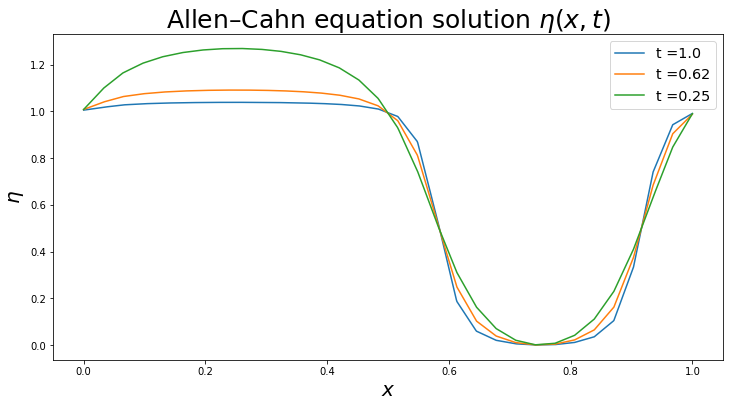

In [23]:
figure(figsize=(12,6))

eta, basis = solve_allen_cahan_non_linear(eta_0, eps=0.01, dt=.03125, ndofs=32, degree=1)

_= plot_solution(eta, basis, 12, 1025)

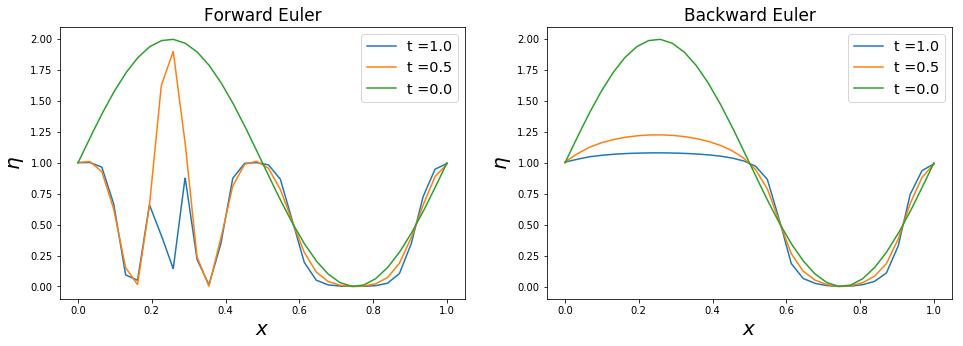

In [28]:
figure(figsize=(16,5))

stride = 2
resolution = 1025

plt.subplot(1, 2, 1)
eta, basis = solve_allen_cahan(eta_0, eps=0.01, dt=0.25, ndofs=32, degree=1)
_= plot_solution(eta, basis, stride, resolution)
_= title("Forward Euler", fontsize=17)

plt.subplot(1, 2, 2)
eta, basis = solve_allen_cahan_non_linear(eta_0, eps=0.01, dt=0.25, ndofs=32, degree=1)
_ = plot_solution(eta, basis, stride, resolution)
_ = title("Backward Euler",  fontsize=17)

For large values of `dt`(i.e. `0.25`) the linear solution is unstable while the nonlinear solution converges. This result is expected, since we know that backward Euler is stable for any time-step value (see [Ordinary Differential Equations](https://people.sissa.it/~grozza/wp-content/uploads/2020/01/Slides_ODE_EN.pdf) )